In [19]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import math
legend_properties = {'weight':'bold'}

In [20]:
import os
import pickle

base_folder = r"E:\data\dao-0310-23\V4_4\Turbulence_Grid_3"

frequencies = [1, 10, 20, 30, 40, 50, 100, 150, 200]   # extend with your list of frequencies
intensities = ["0.05", "0.10", "0.15", "0.20", "0.25", "0.30", "0.35", "0.40"]  # extend with your list of intensities

# the file stubs you want to read (without folder prefix)
file_stubs = [
    "dao_performance_across_turbulence_time",
    "hierarchy_performance_across_turbulence_time",
    "autonomy_performance_across_turbulence_time",
    "dao_diversity_across_turbulence_time",
    "hierarchy_diversity_across_turbulence_time",
    "autonomy_diversity_across_turbulence_time",
    "dao_variance_across_turbulence_time",
    "hierarchy_variance_across_turbulence_time",
    "autonomy_variance_across_turbulence_time"
]

# store results in nested dict: results[frequency][intensity][filename]
results = {}

for f in frequencies:
    results[f] = {}
    for i in intensities:
        folder = os.path.join(base_folder, f"Turbulence_{f}_{i}")
        data_dict = {}
        for stub in file_stubs:
            file_path = os.path.join(folder, stub)
            with open(file_path, 'rb') as infile:
                data_dict[stub] = pickle.load(infile)
        results[f][i] = data_dict



In [21]:
import os
import pickle
import numpy as np
import pandas as pd

# --- Inputs (keep yours) ---
base_folder = r"E:\data\dao-0310-23\V4_4\Turbulence_Grid_3"
frequencies = [1, 10, 20, 30, 40, 50, 100, 150, 200]
intensities = ["0.05", "0.10", "0.15", "0.20", "0.25", "0.30", "0.35", "0.40"]

# fraction of the horizon to treat as "end-state"
k = 0.30  # last 20%; change as needed

# --- Helper ---
def long_term_gap_tail(dao_list, hier_list, tail_frac=0.20):
    dao = np.asarray(dao_list, dtype=float)
    hier = np.asarray(hier_list, dtype=float)
    if len(dao) != len(hier):
        raise ValueError(f"Length mismatch: DAO={len(dao)} vs HIER={len(hier)}")

    n = len(dao)
    if n == 0:
        raise ValueError("Empty performance lists")

    # guard for very short series
    tail_len = max(1, int(round(tail_frac * n)))
    tail_start = n - tail_len

    return float(np.mean(dao[tail_start:] - hier[tail_start:]))

# --- Compute gaps for each folder ---
gaps_nested = {}      # gaps_nested[freq][intensity] = value
rows = []             # tidy rows for CSV/DF

for f in frequencies:
    gaps_nested[f] = {}
    for i in intensities:
        folder = os.path.join(base_folder, f"Turbulence_{f}_{i}")

        # Only the two files we need
        dao_path  = os.path.join(folder, "dao_performance_across_turbulence_time")
        hier_path = os.path.join(folder, "hierarchy_performance_across_turbulence_time")

        # Read
        try:
            with open(dao_path,  'rb') as f_dao, open(hier_path, 'rb') as f_hier:
                dao_perf  = pickle.load(f_dao)
                hier_perf = pickle.load(f_hier)

            gap = long_term_gap_tail(dao_perf, hier_perf, tail_frac=k)
            gaps_nested[f][i] = gap
            rows.append({"frequency": f, "intensity": float(i), "k_tail": k, "long_term_gap_DAO_minus_Hier": gap})

        except FileNotFoundError as e:
            # Record NaN if a folder/file is missing
            gaps_nested[f][i] = np.nan
            rows.append({"frequency": f, "intensity": float(i), "k_tail": k, "long_term_gap_DAO_minus_Hier": np.nan})
            print(f"[WARN] Missing file in {folder}: {e.filename}")
        except Exception as e:
            # Record NaN on any other error but keep going
            gaps_nested[f][i] = np.nan
            rows.append({"frequency": f, "intensity": float(i), "k_tail": k, "long_term_gap_DAO_minus_Hier": np.nan})
            print(f"[WARN] Error computing gap for {folder}: {e}")

# --- Save results ---
# 1) Tidy CSV for quick inspection in Excel/R/Python
out_csv = os.path.join(f"long_term_gap_DAO_minus_Hierarchy_tail_{int(k*100)}pct.csv")
pd.DataFrame(rows).sort_values(["frequency", "intensity"]).to_csv(out_csv, index=False)

# 2) Pickle the nested dict (freq -> intensity -> gap)
out_pkl = os.path.join(f"long_term_gap_DAO_minus_Hierarchy_tail_{int(k*100)}pct.pkl")
with open(out_pkl, "wb") as f_out:
    pickle.dump(gaps_nested, f_out)

print(f"Saved:\n  - {out_csv}\n  - {out_pkl}")

# (Optional) quick peek
df_preview = pd.DataFrame(rows).sort_values(["frequency", "intensity"])
print(df_preview.head(10))

Saved:
  - long_term_gap_DAO_minus_Hierarchy_tail_30pct.csv
  - long_term_gap_DAO_minus_Hierarchy_tail_30pct.pkl
   frequency  intensity  k_tail  long_term_gap_DAO_minus_Hier
0          1       0.05     0.3                     -0.000021
1          1       0.10     0.3                     -0.001259
2          1       0.15     0.3                     -0.003226
3          1       0.20     0.3                     -0.003781
4          1       0.25     0.3                     -0.003920
5          1       0.30     0.3                     -0.003685
6          1       0.35     0.3                     -0.003464
7          1       0.40     0.3                     -0.003200
8         10       0.05     0.3                     -0.000186
9         10       0.10     0.3                     -0.001098


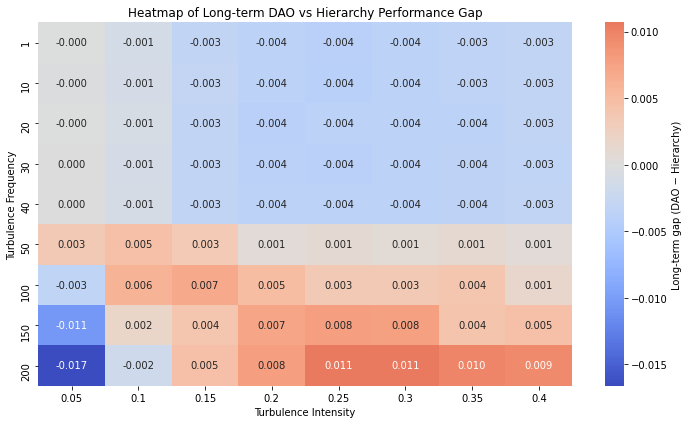

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your CSV if needed
out_csv = f"long_term_gap_DAO_minus_Hierarchy_tail_{int(k*100)}pct.csv"
df = pd.read_csv(out_csv)

# Make sure intensity is numeric for sorting
df["intensity"] = df["intensity"].astype(float)

# Pivot into matrix: rows = frequency, cols = intensity
heatmap_data = df.pivot(index="frequency", columns="intensity", values="long_term_gap_DAO_minus_Hier")

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True, fmt=".3f", cmap="coolwarm", center=0,
    cbar_kws={'label': 'Long-term gap (DAO − Hierarchy)'}
)

plt.title("Heatmap of Long-term DAO vs Hierarchy Performance Gap")
plt.xlabel("Turbulence Intensity")
plt.ylabel("Turbulence Frequency")
plt.tight_layout()
plt.show()


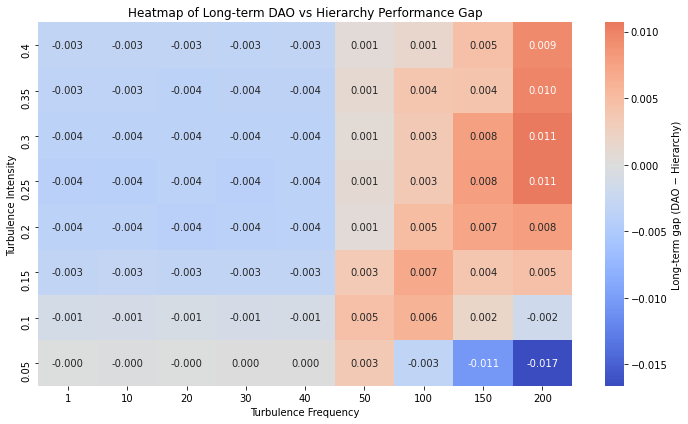

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure numeric type for sorting
df["intensity"] = df["intensity"].astype(float)

# Pivot with intensities as rows
heatmap_data = df.pivot(index="intensity", columns="frequency", values="long_term_gap_DAO_minus_Hier")

# Reindex to enforce ascending intensity
heatmap_data = heatmap_data.sort_index(ascending=True)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    heatmap_data,
    annot=True, fmt=".3f", cmap="coolwarm", center=0,
    cbar_kws={'label': 'Long-term gap (DAO − Hierarchy)'}
)

plt.title("Heatmap of Long-term DAO vs Hierarchy Performance Gap")
plt.xlabel("Turbulence Frequency")
plt.ylabel("Turbulence Intensity")

# Flip so that small intensities are at the bottom
ax.invert_yaxis()

plt.tight_layout()
plt.show()
